In [203]:
#|default_exp graphdataset

In [204]:
#| export

from pathlib import Path
import torch
import pandas as pd
import numpy as np
from copy import deepcopy
from datasets import  load_from_disk
from scipy.interpolate import interp1d
from sklearn.preprocessing import RobustScaler

from graphnet.models.components.pool import (
    sum_pool_and_distribute,
)

In [205]:
from pdb import set_trace
import seaborn as sns
class CFG:
    CACHE_PATH = Path('../data/cache')

In [206]:
fns = list((CFG.CACHE_PATH/'batch_3').glob('*.pth'))

In [207]:
# | export
from torch_geometric.data import Data
from torch_geometric.data import Dataset as gDataset
from torch_geometric.loader import DataLoader as gDataLoader
from graphnet.models.graph_builders import KNNGraphBuilder


def add_features_to_batch(batch):
    '''add features to batch + 2'''
    charge = batch.x[:, 4].unsqueeze(-1)
    center_of_gravity = sum_pool_and_distribute(
                batch.pos * charge, batch.batch
            ) / sum_pool_and_distribute(charge, batch.batch)
    vector_to_center_of_gravity = center_of_gravity - batch.pos
    distance_to_center_of_gravity = torch.norm(
                vector_to_center_of_gravity, p=2, dim=1
            )
    unit_vector_to_center_of_gravity = vector_to_center_of_gravity / (
                distance_to_center_of_gravity.unsqueeze(dim=1) + 1e-3
            )
    cos_angle_wrt_center_of_gravity = (
                batch.pos * unit_vector_to_center_of_gravity
            ).sum(dim=1)
    
    out = torch.cat(
            (
                batch.x,
                distance_to_center_of_gravity.unsqueeze(dim=1),
                cos_angle_wrt_center_of_gravity.unsqueeze(dim=1),
            ),
            dim=1,
        )
    return out


# function to normalize input between 1 and 0
def normalize(x):
    return (x - x.min()) / (x.max() - x.min())

#| export
def ice_transparency(
    data_path="/opt/slh/icecube/data/ice_transparency.txt", datum=1950
):
    # Data from page 31 of https://arxiv.org/pdf/1301.5361.pdf
    # Datum is from footnote 8 of page 29
    df = pd.read_csv(data_path, delim_whitespace=True)
    df["z"] = df["depth"] - datum
    df["z_norm"] = df["z"] / 500
    df[["scattering_len_norm", "absorption_len_norm"]] = RobustScaler().fit_transform(
        df[["scattering_len", "absorption_len"]]
    )

    # These are both roughly equivalent after scaling
    f_scattering = interp1d(df["z_norm"], df["scattering_len_norm"])
    f_absorption = interp1d(df["z_norm"], df["absorption_len_norm"])
    return f_scattering, f_absorption

def prepare_sensors():
    sensors = pd.read_csv('/opt/slh/icecube/data/sensor_geometry.csv').astype(
        {
            "sensor_id": np.int16,
            "x": np.float32,
            "y": np.float32,
            "z": np.float32,
        }
    )
    sensors["string"] = 0
    sensors["qe"] = 1

    for i in range(len(sensors) // 60):
        start, end = i * 60, (i * 60) + 60
        sensors.loc[start:end, "string"] = i

        # High Quantum Efficiency in the lower 50 DOMs - https://arxiv.org/pdf/2209.03042.pdf (Figure 1)
        if i in range(78, 86):
            start_veto, end_veto = i * 60, (i * 60) + 10
            start_core, end_core = end_veto + 1, (i * 60) + 60
            sensors.loc[start_core:end_core, "qe"] = 1.35

    # https://github.com/graphnet-team/graphnet/blob/b2bad25528652587ab0cdb7cf2335ee254cfa2db/src/graphnet/models/detector/icecube.py#L33-L41
    # Assume that "rde" (relative dom efficiency) is equivalent to QE
    sensors["x"] /= 500
    sensors["y"] /= 500
    sensors["z"] /= 500
    sensors["qe"] -= 1.25
    sensors["qe"] /= 0.25

    return sensors.set_index("sensor_id")[['qe']]


def convert_to_3d(azimuth, zenith):
    """Converts zenith and azimuth to 3D direction vectors"""
    x = np.cos(azimuth) * np.sin(zenith)
    y = np.sin(azimuth) * np.sin(zenith)
    z = np.cos(zenith)
    return np.array([x, y, z], dtype=np.float32)

def event_filtering_v1(batch, max_pulse_count=128, t_valid_length=6199.700247193777):
    col = batch.columns
    t_peak = batch["time"][batch["charge"].argmax()]
    t_valid_min = t_peak - t_valid_length
    t_valid_max = t_peak + t_valid_length
    t_valid = (batch["time"] > t_valid_min) * (batch["time"] < t_valid_max)
    batch["rank"] = 2 * (1 - batch["auxiliary"]) + (t_valid)
    batch = batch.sort_values(by=["rank", "charge"])
    # pick-up from backward
    batch = batch[-max_pulse_count:]
        # resort by time
    batch = batch.sort_values(by="time")
    return batch[col]


def get_distance_matrix(xyz):
    return torch.cdist(xyz, xyz)


def get_distance_matrix_for_indices(dm, indices):
    return dm[indices][:, indices]


def get_distance_matrix_from_csv(
    path_to_geom="/opt/slh/icecube/data/sensor_geometry.csv",
):
    geom = pd.read_csv(path_to_geom)[["x", "y", "z"]]
    geom = torch.tensor(geom.values, dtype=torch.float32)
    geom = get_distance_matrix(geom)
    # nromalize goematry matrix
    geom = geom / geom.max()
    return geom
    

class GraphDasetV0(gDataset):
    def __init__(
        self,
        ds,
        max_events=196,
        transform=None,
        pre_transform= KNNGraphBuilder(nb_nearest_neighbours=8, columns=[0, 1, 2, 3]),
        pre_filter=None,
    ):
        super().__init__(transform, pre_transform, pre_filter)
        self.ds = ds
        self.max_events = max_events
        self.f_scattering, self.f_absorption = ice_transparency()
        self.sensor_data = prepare_sensors()


    def len(self):
        return len(self.ds)

    def get(self, idx):
        item = self.ds[idx]

        event = pd.DataFrame(item)[
            [
                "time",
                "charge",
                "auxiliary",
                "x",
                "y",
                "z",
                "sensor_id"
            ]
        ].astype(np.float32)
        t = (event["time"].values - 1.0e04) / 3.0e4
        event["time"] /= event["time"].max()

        if event.shape[0] > self.max_events:
            event = event_filtering_v1(event, max_pulse_count=self.max_events)

        event[["x", "y", "z"]] /= 500
        event["charge"] = np.log10(event["charge"]) / 3.0
        event["auxiliary"] -= 0.5

        event["time"] = t[: self.max_events]
        event["scattering"] = self.f_scattering(event["z"].values).reshape(-1)
        event["absorption"] = self.f_absorption(event["z"].values).reshape(-1)
        event['qe'] = self.sensor_data.loc[event['sensor_id'].values].values.reshape(-1)
        event = torch.tensor(event[
            [
                "x",
                "y",
                "z",
                "time",
                "charge",
                "auxiliary",
                "qe",
                "scattering",
                "absorption",
            ]
        ].values, dtype=torch.float32)
        
        label = torch.tensor(convert_to_3d(item["azimuth"], item["zenith"]), dtype=torch.float32)
        #print(item["azimuth"], item["zenith"])    
    
        data = Data(x=deepcopy(event), 
                    pos= event[:, :3],
                    n_pulses=torch.tensor(event.shape[0],
                                          dtype=torch.int32), 
                    y = label)
        
        return data
    
    
class GraphDasetV1(gDataset):
    "same as GraphDasetV0 but with eventid"
    def __init__(
        self,
        ds,
        max_events=196,
        transform=None,
        pre_transform= KNNGraphBuilder(nb_nearest_neighbours=9, columns=[0, 1, 2, 3]),
        pre_filter=None,
    ):
        super().__init__(transform, pre_transform, pre_filter)
        self.ds = ds
        self.max_events = max_events
        self.f_scattering, self.f_absorption = ice_transparency()
        self.sensor_data = prepare_sensors()


    def len(self):
        return len(self.ds)

    def get(self, idx):
        item = self.ds[idx]

        event = pd.DataFrame(item)[
            [
                "time",
                "charge",
                "auxiliary",
                "x",
                "y",
                "z",
                "sensor_id"
            ]
        ].astype(np.float32)
        t = (event["time"].values - 1.0e04) / 3.0e4
        event["time"] /= event["time"].max()

        if event.shape[0] > self.max_events:
            event = event_filtering_v1(event, max_pulse_count=self.max_events)

        event[["x", "y", "z"]] /= 500
        event["charge"] = np.log10(event["charge"]) / 3.0
        event["auxiliary"] -= 0.5

        event["time"] = t[: self.max_events]
        event["scattering"] = self.f_scattering(event["z"].values).reshape(-1)
        event["absorption"] = self.f_absorption(event["z"].values).reshape(-1)
        event['qe'] = self.sensor_data.loc[event['sensor_id'].values].values.reshape(-1)
        event = torch.tensor(event[
            [
                "x",
                "y",
                "z",
                "time",
                "charge",
                "auxiliary",
                "qe",
                "scattering",
                "absorption",
                "sensor_id"
            ]
        ].values, dtype=torch.float32)
        
        label = torch.tensor(convert_to_3d(item["azimuth"], item["zenith"]), dtype=torch.float32)
        #print(item["azimuth"], item["zenith"])    
    
        data = Data(x=deepcopy(event[:, :-1]), 
                    pos= event[:, :3],
                    n_pulses=torch.tensor(event.shape[0],
                                          dtype=torch.int32), 
                    sensor_id = event[:, -1].int(),
                    y = label)
        
        return data
    
    
class GraphDasetV3(gDataset):
    'same as V0 but with 128 events'
    def __init__(
        self,
        ds,
        max_events=128,
        transform=None,
        pre_transform= KNNGraphBuilder(nb_nearest_neighbours=8, columns=[0, 1, 2, 3]),
        pre_filter=None,
    ):
        super().__init__(transform, pre_transform, pre_filter)
        self.ds = ds
        self.max_events = max_events
        self.f_scattering, self.f_absorption = ice_transparency()
        self.sensor_data = prepare_sensors()


    def len(self):
        return len(self.ds)

    def get(self, idx):
        item = self.ds[idx]

        event = pd.DataFrame(item)[
            [
                "time",
                "charge",
                "auxiliary",
                "x",
                "y",
                "z",
                "sensor_id"
            ]
        ].astype(np.float32)
        t = (event["time"].values - 1.0e04) / 3.0e4
        event["time"] /= event["time"].max()

        if event.shape[0] > self.max_events:
            event = event_filtering_v1(event, max_pulse_count=self.max_events)

        event[["x", "y", "z"]] /= 500
        event["charge"] = np.log10(event["charge"]) / 3.0
        event["auxiliary"] -= 0.5

        event["time"] = t[: self.max_events]
        event["scattering"] = self.f_scattering(event["z"].values).reshape(-1)
        event["absorption"] = self.f_absorption(event["z"].values).reshape(-1)
        event['qe'] = self.sensor_data.loc[event['sensor_id'].values].values.reshape(-1)
        event = torch.tensor(event[
            [
                "x",
                "y",
                "z",
                "time",
                "charge",
                "auxiliary",
                "qe",
                "scattering",
                "absorption",
            ]
        ].values, dtype=torch.float32)
        
        label = torch.tensor(convert_to_3d(item["azimuth"], item["zenith"]), dtype=torch.float32)
        #print(item["azimuth"], item["zenith"])    
    
        data = Data(x=deepcopy(event), 
                    pos= event[:, :3],
                    n_pulses=torch.tensor(event.shape[0],
                                          dtype=torch.int32), 
                    y = label)
        
        return data
    
    
class GraphDasetV4(gDataset):
    def __init__(
        self,
        ds,
        max_events=196,
        transform=None,
        pre_transform= KNNGraphBuilder(nb_nearest_neighbours=7, columns=[0, 1, 2, 3, 4]),
        pre_filter=None,
    ):
        super().__init__(transform, pre_transform, pre_filter)
        self.ds = ds
        self.max_events = max_events
        self.f_scattering, self.f_absorption = ice_transparency()
        self.sensor_data = prepare_sensors()


    def len(self):
        return len(self.ds)

    def get(self, idx):
        item = self.ds[idx]

        event = pd.DataFrame(item)[
            [
                "time",
                "charge",
                "auxiliary",
                "x",
                "y",
                "z",
                "sensor_id"
            ]
        ].astype(np.float32)
        t = (event["time"].values - 1.0e04) / 3.0e4
        event["time"] /= event["time"].max()

        if event.shape[0] > self.max_events:
            event = event_filtering_v1(event, max_pulse_count=self.max_events)

        event[["x", "y", "z"]] /= 500
        event["charge"] = np.log10(event["charge"]) / 3.0

        event["time"] = t[: self.max_events]
        event["scattering"] = self.f_scattering(event["z"].values).reshape(-1)
        event["absorption"] = self.f_absorption(event["z"].values).reshape(-1)
        event['qe'] = self.sensor_data.loc[event['sensor_id'].values].values.reshape(-1)
        event_ = torch.tensor(event[
            [
                "x",
                "y",
                "z",
                "time",
                "charge",
                "scattering",
                "absorption",
            ]
        ].values, dtype=torch.float32)
        
        label = torch.tensor(convert_to_3d(item["azimuth"], item["zenith"]), dtype=torch.float32)
        #print(item["azimuth"], item["zenith"])    
    
        data = Data(x=deepcopy(event_), 
                    pos= event_[:, :3],
                    n_pulses=torch.tensor(event.shape[0],
                                          dtype=torch.int32), 
                    qe = torch.tensor(event['qe'].values + 1, dtype=torch.long),
                    aux= torch.tensor(event['auxiliary'].values, dtype=torch.long),
                    y = label)
        
        return data


In [208]:
ds = GraphDasetV4(load_from_disk('/opt/slh/icecube/data/hf_cashe/batch_1.parquet'))

In [209]:
ds[0]

Data(x=[61, 7], y=[3], pos=[61, 3], n_pulses=61, qe=[61], aux=[61], edge_index=[2, 427])

In [210]:
#|hide
#|eval: false
from nbdev.doclinks import nbdev_export
nbdev_export()

In [211]:
ds[0]

Data(x=[61, 7], y=[3], pos=[61, 3], n_pulses=61, qe=[61], aux=[61], edge_index=[2, 427])

In [212]:
from torch_geometric.utils import to_dense_batch
from torch_geometric.data import DataLoader as gDataLoader

In [213]:

dl = gDataLoader(ds, batch_size=10, shuffle=False)
batch = next(iter(dl))

/opt/conda/lib/python3.7/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [214]:
import matplotlib.pyplot as plt
index = np.random.randint(0, 200000)
index
index = 2307

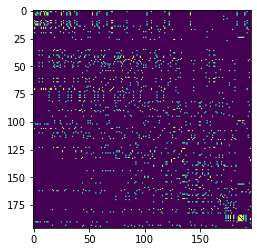

In [215]:
ds = GraphDasetV4(load_from_disk('/opt/slh/icecube/data/hf_cashe/batch_1.parquet'), 
                  pre_transform= KNNGraphBuilder(nb_nearest_neighbours=8, columns=[0, 1, 2]))
plt.imshow(to_dense_adj(ds[index].edge_index)[0])

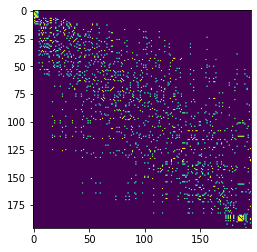

In [216]:
ds = GraphDasetV4(load_from_disk('/opt/slh/icecube/data/hf_cashe/batch_1.parquet'), 
                  pre_transform= KNNGraphBuilder(nb_nearest_neighbours=8, columns=[0, 1, 2, 3]))
plt.imshow(to_dense_adj(ds[index].edge_index)[0])

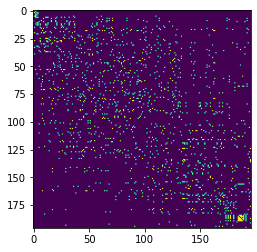

In [217]:
ds = GraphDasetV4(load_from_disk('/opt/slh/icecube/data/hf_cashe/batch_1.parquet'), 
                  pre_transform= KNNGraphBuilder(nb_nearest_neighbours=8, columns=[0, 1, 2, 3, 4]))
plt.imshow(to_dense_adj(ds[index].edge_index)[0])